[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


Processed Sample Rate: 16000
Duration: 4.5001875


Loading weights:   0%|          | 0/212 [00:00<?, ?it/s]

Wav2Vec2ForCTC LOAD REPORT from: facebook/wav2vec2-base-960h
Key                        | Status  | 
---------------------------+---------+-
wav2vec2.masked_spec_embed | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



Recognized Text:
MADE CERTAIN RECOMMENDATIONS WHICH IT BELIEVES WOULD IF ADOPTED

Converted Phonemes:
['M', 'EY1', 'D', 'S', 'ER1', 'T', 'AH0', 'N', 'R', 'EH2', 'K', 'AH0', 'M', 'AH0', 'N', 'D', 'EY1', 'SH', 'AH0', 'N', 'Z', 'W', 'IH1', 'CH', 'IH1', 'T', 'B', 'IH0', 'L', 'IY1', 'V', 'Z', 'W', 'UH1', 'D', 'IH1', 'F', 'AH0', 'D', 'AA1', 'P', 'T', 'AH0', 'D']

Phoneme: M
Category: Other
Start: 0.0 End: 0.102


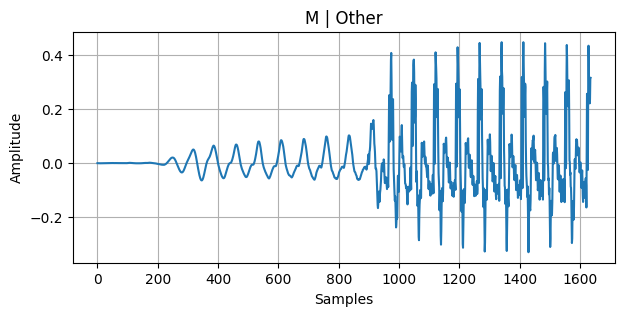


Phoneme: EY1
Category: Other
Start: 0.102 End: 0.205


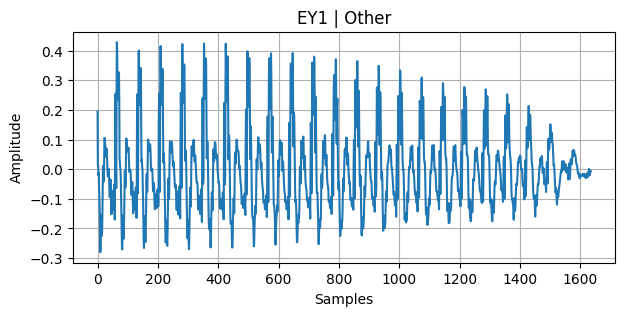


Phoneme: D
Category: Plosive (Air Burst)
Start: 0.205 End: 0.307


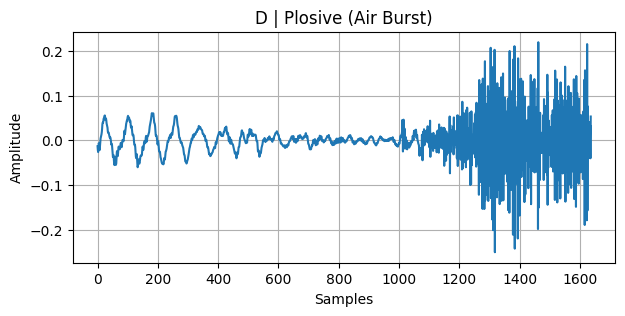


Phoneme: S
Category: Fricative (Turbulent Airflow)
Start: 0.307 End: 0.409


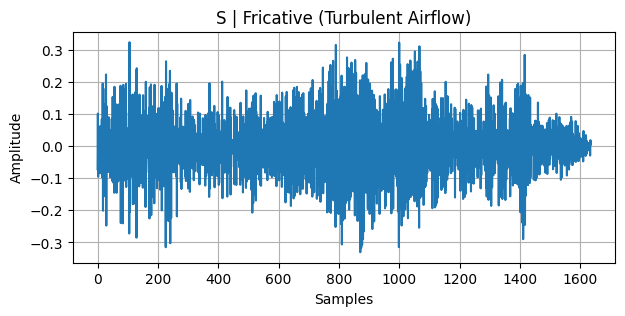


Phoneme: ER1
Category: Other
Start: 0.409 End: 0.511


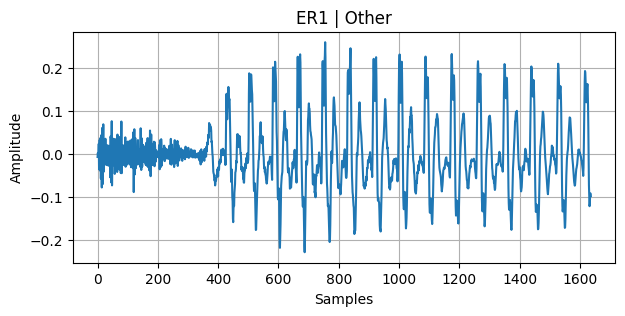


Phoneme: T
Category: Plosive (Air Burst)
Start: 0.511 End: 0.614


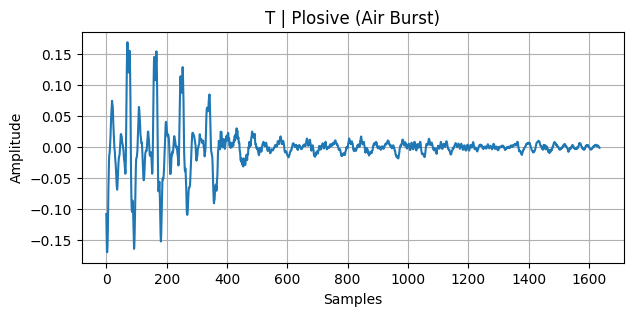


Phoneme: AH0
Category: Other
Start: 0.614 End: 0.716


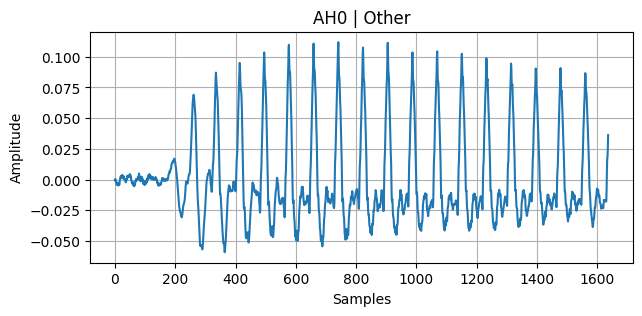


Phoneme: N
Category: Other
Start: 0.716 End: 0.818


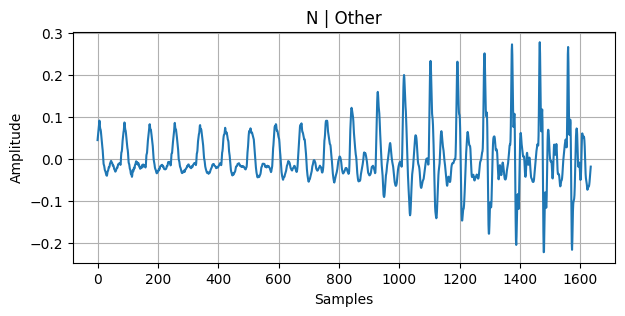


Phoneme: R
Category: Approximant (Smooth/Laminar)
Start: 0.818 End: 0.92


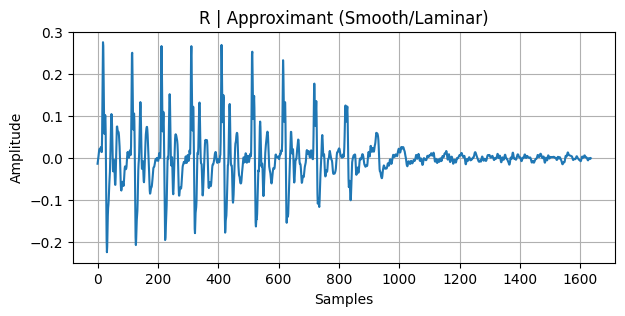


Phoneme: EH2
Category: Other
Start: 0.92 End: 1.023


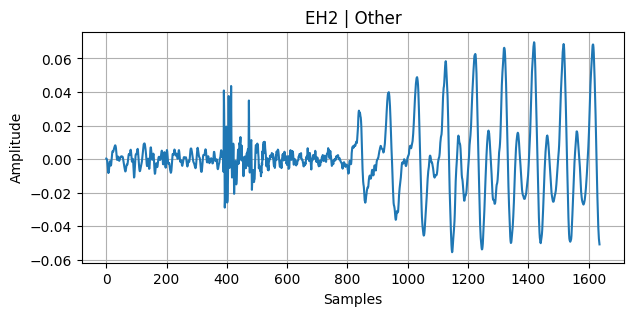


Phoneme: K
Category: Plosive (Air Burst)
Start: 1.023 End: 1.125


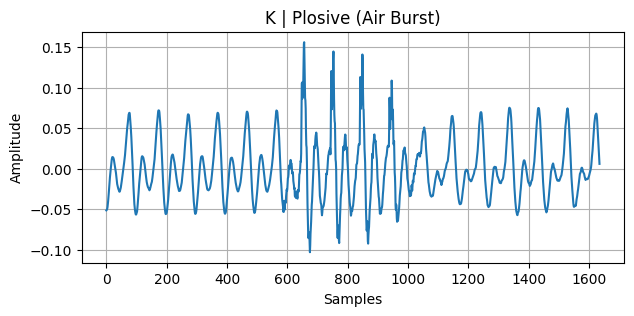


Phoneme: AH0
Category: Other
Start: 1.125 End: 1.227


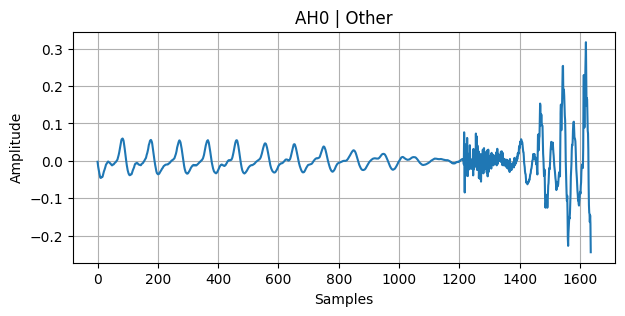


Phoneme: M
Category: Other
Start: 1.227 End: 1.33


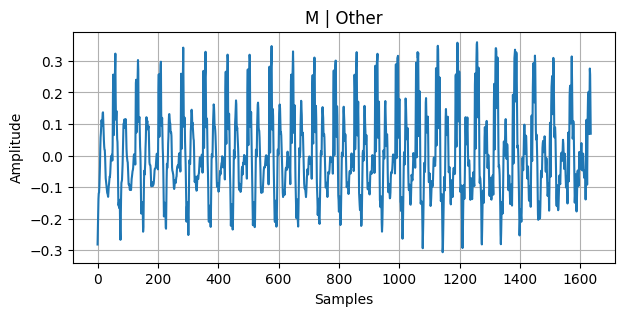


Phoneme: AH0
Category: Other
Start: 1.33 End: 1.432


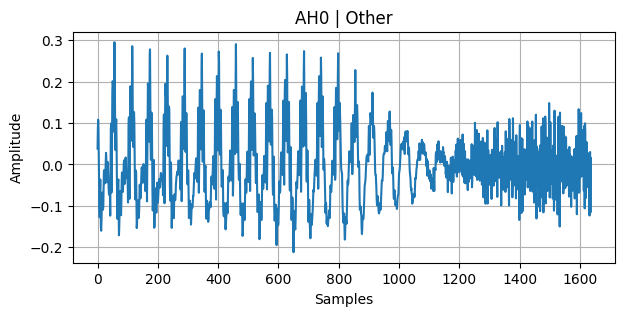


Phoneme: N
Category: Other
Start: 1.432 End: 1.534


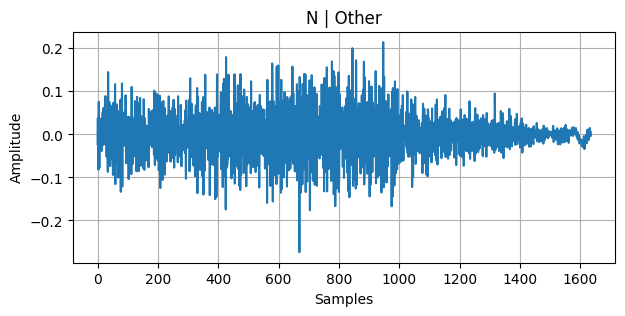


Phoneme: D
Category: Plosive (Air Burst)
Start: 1.534 End: 1.636


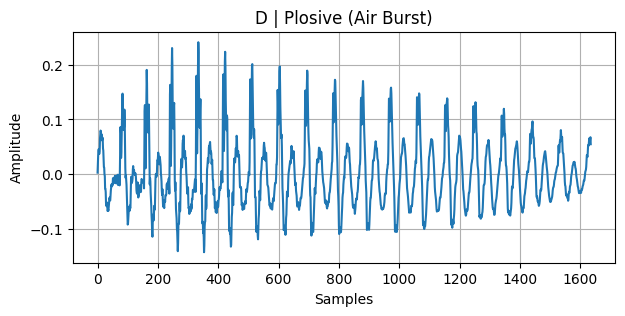


Phoneme: EY1
Category: Other
Start: 1.636 End: 1.739


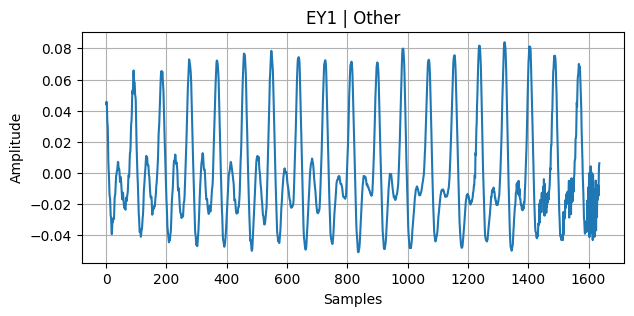


Phoneme: SH
Category: Fricative (Turbulent Airflow)
Start: 1.739 End: 1.841


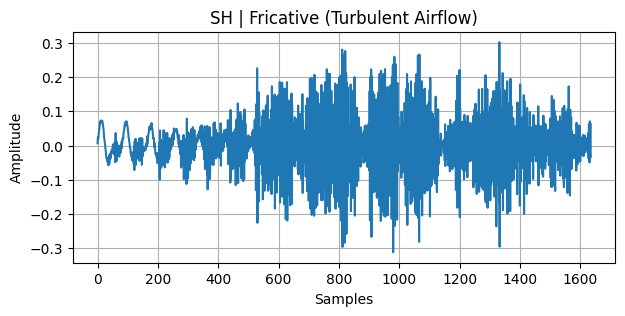


Phoneme: AH0
Category: Other
Start: 1.841 End: 1.943


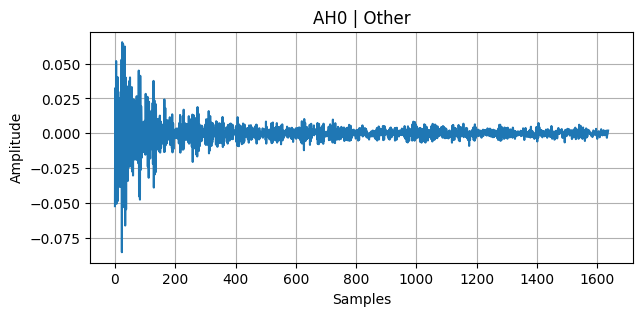


Phoneme: N
Category: Other
Start: 1.943 End: 2.046


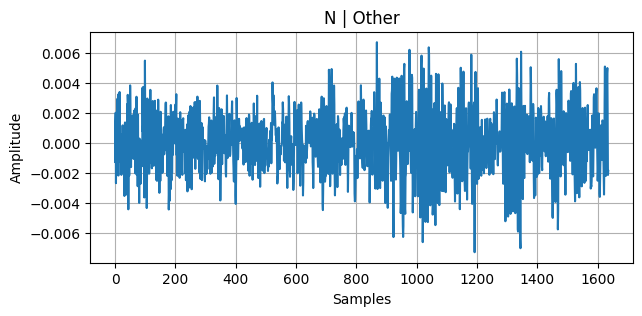


Phoneme: Z
Category: Fricative (Turbulent Airflow)
Start: 2.046 End: 2.148


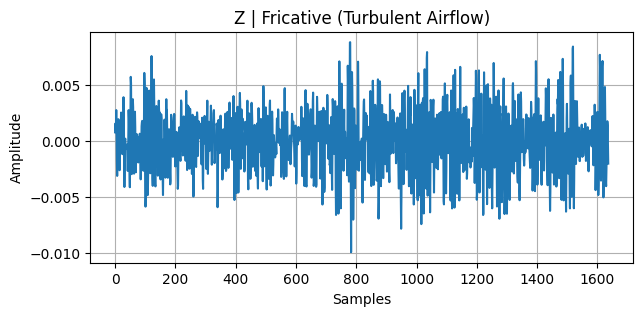


Phoneme: W
Category: Approximant (Smooth/Laminar)
Start: 2.148 End: 2.25


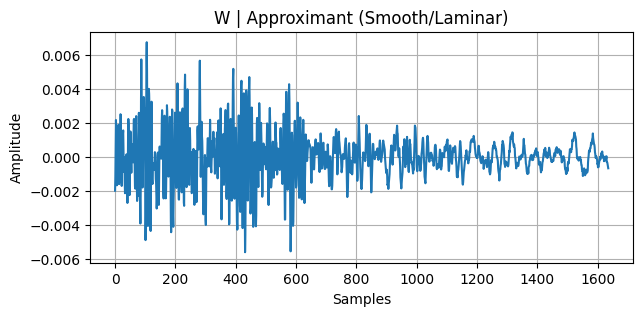


Phoneme: IH1
Category: Other
Start: 2.25 End: 2.352


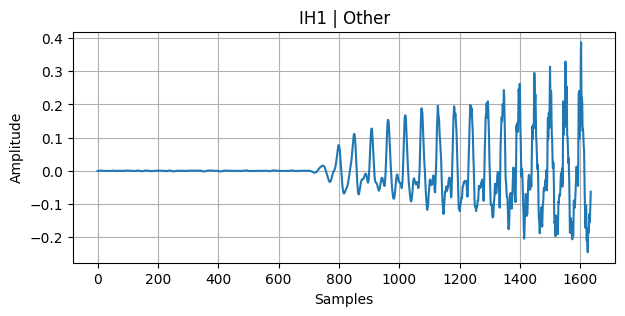


Phoneme: CH
Category: Other
Start: 2.352 End: 2.455


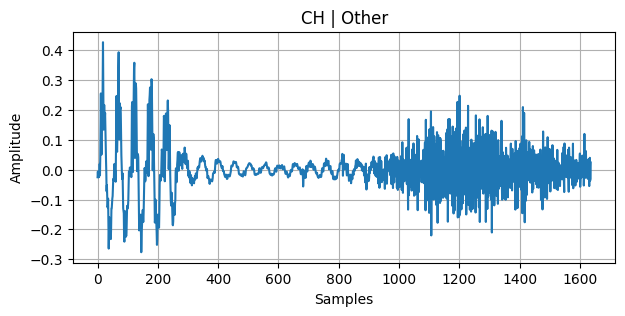


Phoneme: IH1
Category: Other
Start: 2.455 End: 2.557


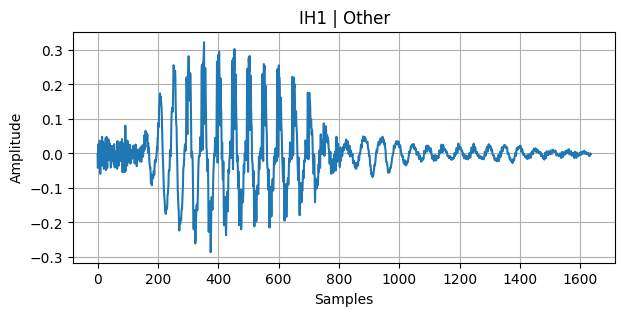


Phoneme: T
Category: Plosive (Air Burst)
Start: 2.557 End: 2.659


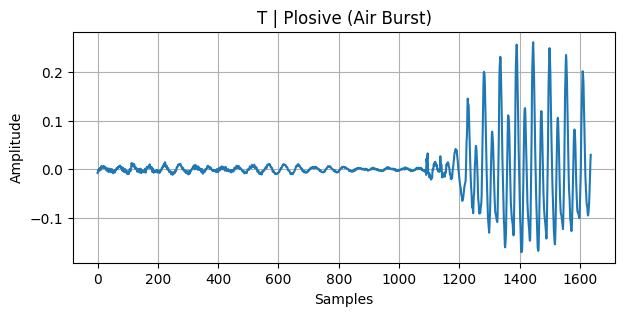


Phoneme: B
Category: Plosive (Air Burst)
Start: 2.659 End: 2.761


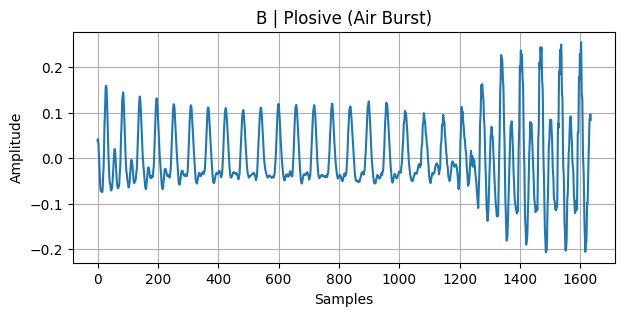


Phoneme: IH0
Category: Other
Start: 2.761 End: 2.864


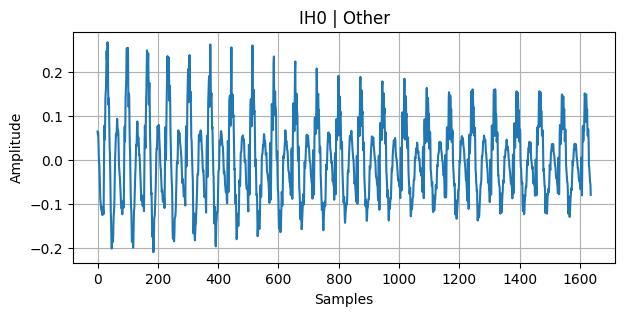


Phoneme: L
Category: Approximant (Smooth/Laminar)
Start: 2.864 End: 2.966


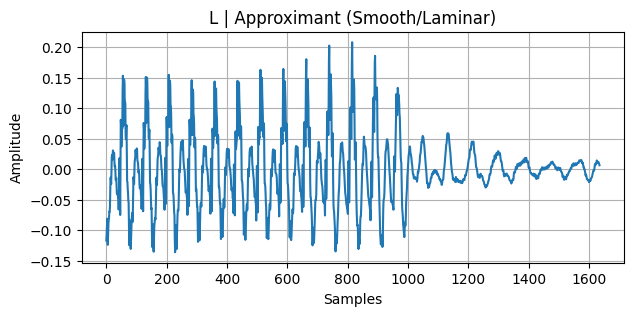


Phoneme: IY1
Category: Other
Start: 2.966 End: 3.068


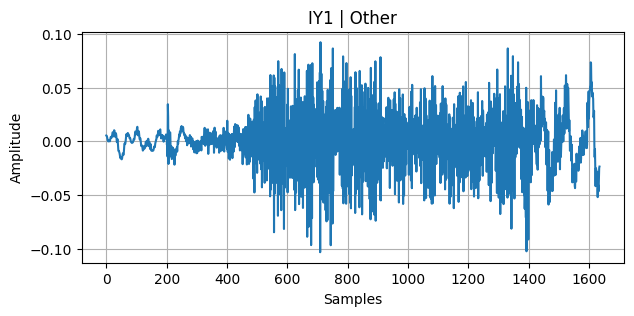


Phoneme: V
Category: Fricative (Turbulent Airflow)
Start: 3.068 End: 3.171


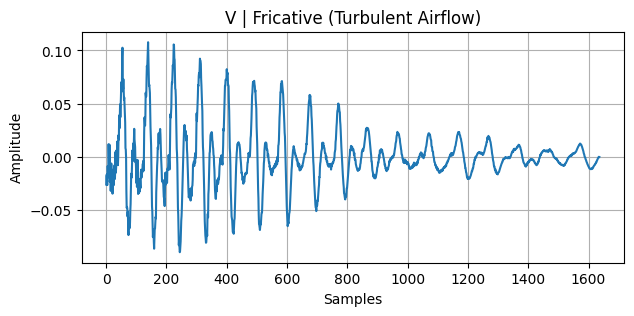


Phoneme: Z
Category: Fricative (Turbulent Airflow)
Start: 3.171 End: 3.273


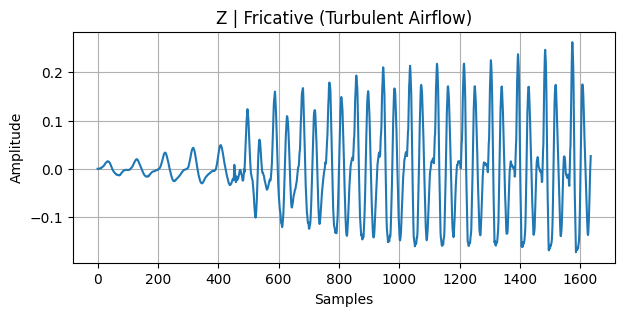


Phoneme: W
Category: Approximant (Smooth/Laminar)
Start: 3.273 End: 3.375


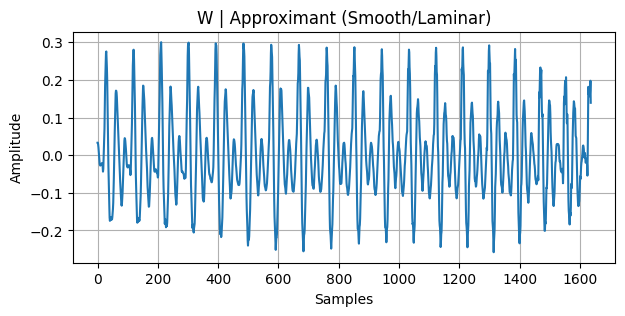


Phoneme: UH1
Category: Other
Start: 3.375 End: 3.477


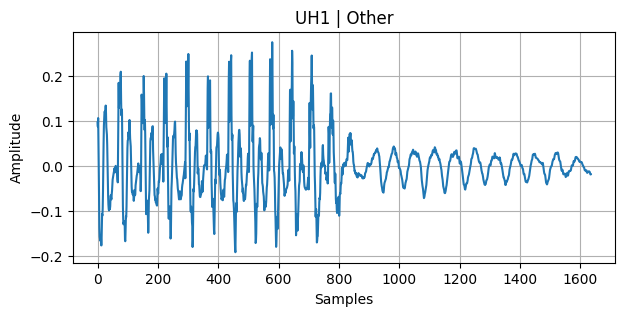


Phoneme: D
Category: Plosive (Air Burst)
Start: 3.477 End: 3.58


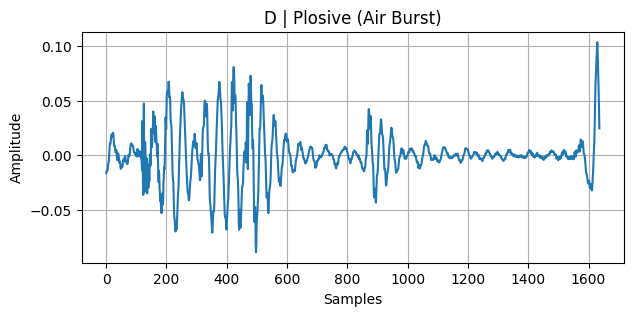


Phoneme: IH1
Category: Other
Start: 3.58 End: 3.682


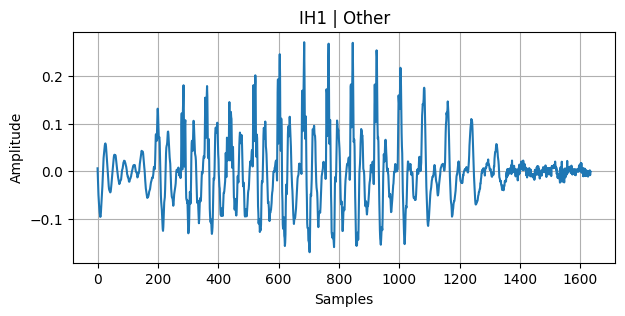


Phoneme: F
Category: Fricative (Turbulent Airflow)
Start: 3.682 End: 3.784


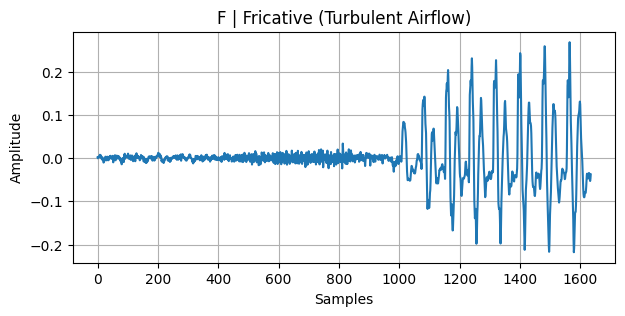


Phoneme: AH0
Category: Other
Start: 3.784 End: 3.887


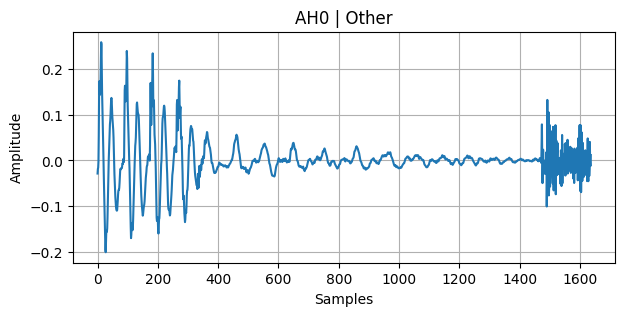


Phoneme: D
Category: Plosive (Air Burst)
Start: 3.887 End: 3.989


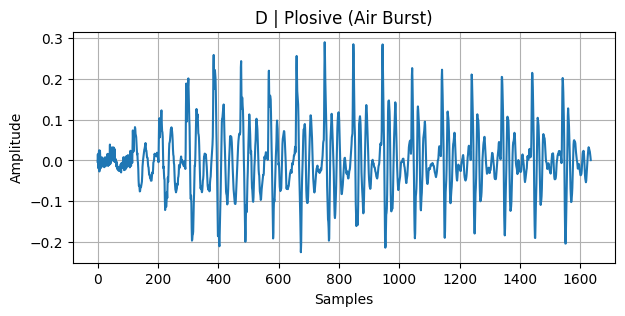


Phoneme: AA1
Category: Other
Start: 3.989 End: 4.091


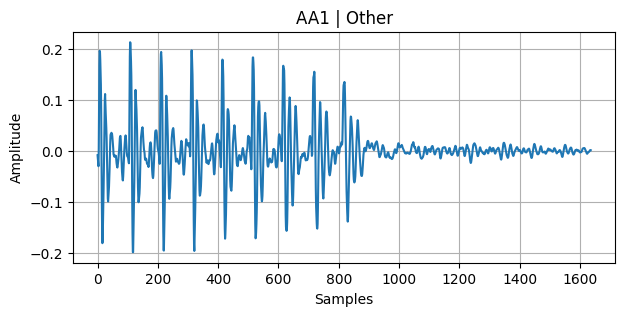


Phoneme: P
Category: Plosive (Air Burst)
Start: 4.091 End: 4.193


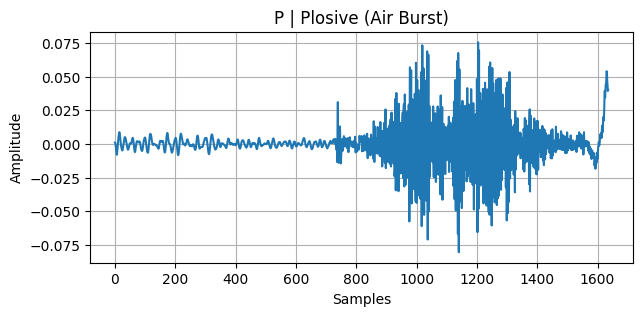


Phoneme: T
Category: Plosive (Air Burst)
Start: 4.193 End: 4.296


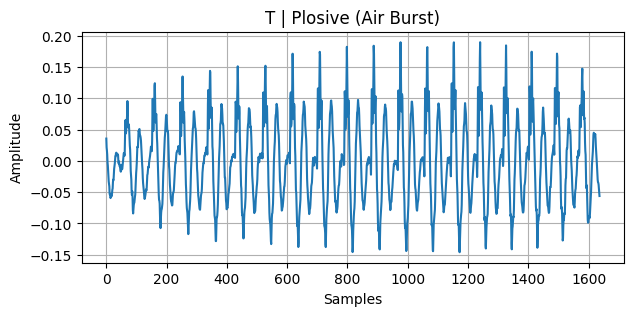


Phoneme: AH0
Category: Other
Start: 4.296 End: 4.398


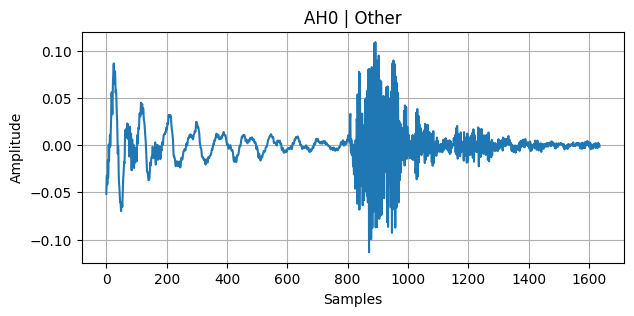


Phoneme: D
Category: Plosive (Air Burst)
Start: 4.398 End: 4.5


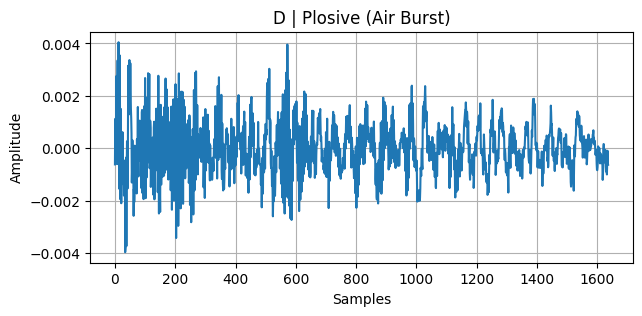


All phonemes extracted successfully.


In [8]:

!pip install transformers torchaudio librosa g2p_en

import torch
import torchaudio
import librosa
import matplotlib.pyplot as plt
import numpy as np
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from g2p_en import G2p
import nltk


nltk.download('averaged_perceptron_tagger_eng')
nltk.download('cmudict')


audio_path = "/content/LJ050-0274.wav"

waveform, sample_rate = torchaudio.load(audio_path)


if waveform.shape[0] > 1:
    waveform = torch.mean(waveform, dim=0, keepdim=True)


target_sr = 16000
if sample_rate != target_sr:
    resampler = torchaudio.transforms.Resample(sample_rate, target_sr)
    waveform = resampler(waveform)

speech = waveform.squeeze().numpy()
sample_rate = target_sr
duration = len(speech) / sample_rate

print("Processed Sample Rate:", sample_rate)
print("Duration:", duration)


processor = Wav2Vec2Processor.from_pretrained(
    "facebook/wav2vec2-base-960h"
)
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base-960h"
)
model.eval()


inputs = processor(
    speech,
    sampling_rate=16000,
    return_tensors="pt",
    padding=True
)

with torch.no_grad():
    logits = model(inputs.input_values).logits

predicted_ids = torch.argmax(logits, dim=-1)
transcription = processor.decode(predicted_ids[0])

print("\nRecognized Text:")
print(transcription)


g2p = G2p()
phonemes = g2p(transcription)


phonemes = [p for p in phonemes if p != " "]

print("\nConverted Phonemes:")
print(phonemes)


num_phonemes = len(phonemes)
time_per_phoneme = duration / num_phonemes


vowels = ["AA","AE","AH","AO","EH","IH","IY","UH","UW"]
fricatives = ["S","Z","SH","F","V","TH","DH","HH"]
plosives = ["P","B","T","D","K","G"]
approximants = ["Y","W","L","R"]

def classify_phoneme(p):
    if p in vowels:
        return "Vowel (Voiced, Periodic)"
    elif p in fricatives:
        return "Fricative (Turbulent Airflow)"
    elif p in plosives:
        return "Plosive (Air Burst)"
    elif p in approximants:
        return "Approximant (Smooth/Laminar)"
    else:
        return "Other"


for i, phoneme in enumerate(phonemes):

    start_time = i * time_per_phoneme
    end_time = start_time + time_per_phoneme

    start_sample = int(start_time * sample_rate)
    end_sample = int(end_time * sample_rate)

    segment = speech[start_sample:end_sample]

    if len(segment) == 0:
        continue

    category = classify_phoneme(phoneme)

    print("\nPhoneme:", phoneme)
    print("Category:", category)
    print("Start:", round(start_time,3),
          "End:", round(end_time,3))


    output_file = f"phoneme_{i}_{phoneme}.wav"
    torchaudio.save(
        output_file,
        torch.tensor(segment).unsqueeze(0),
        sample_rate
    )


    plt.figure(figsize=(7,3))
    plt.plot(segment)
    plt.title(f"{phoneme} | {category}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

print("\nAll phonemes extracted successfully.")